## Dependencies

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading the data

In [2]:
data = tfds.load('fashion_mnist', split='train')

2023-02-17 10:16:57.116328: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
data.as_numpy_iterator().next().keys()

2023-02-17 10:17:53.560215: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


dict_keys(['image', 'label'])

## Data Visualization

In [4]:
dataiterator = data.as_numpy_iterator()

In [5]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

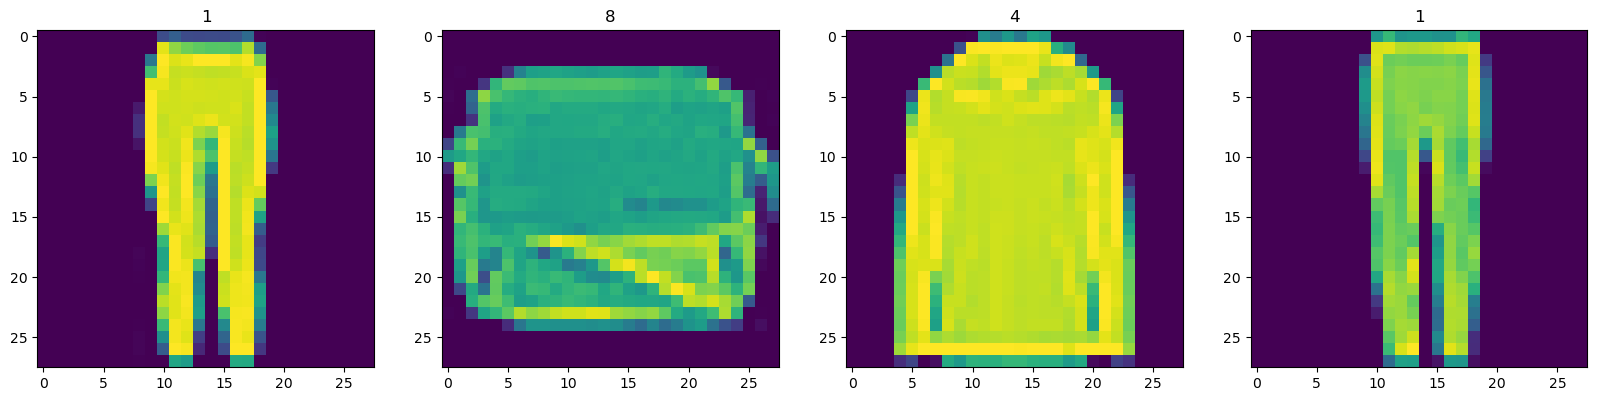

In [6]:
fig, ax =plt.subplots(ncols= 4, figsize=(20, 20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

## preprocessing

In [7]:
def scale_images(data):
    image = data['image']
    return image / 255

Preparing data for tensorflow

In [8]:
data = data.map(scale_images)
data = data.cache()
data = data.shuffle(60000)
data = data.batch(128)
data = data.prefetch(64)

In [9]:
print(data)

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [10]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Neural Network

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## Generator

In [12]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim= 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding= 'same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding= 'same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding= 'same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding= 'same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1, 4, padding= 'same', activation= 'sigmoid'))
    
    return model

In [13]:
generator = build_generator()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 6s 6s/step


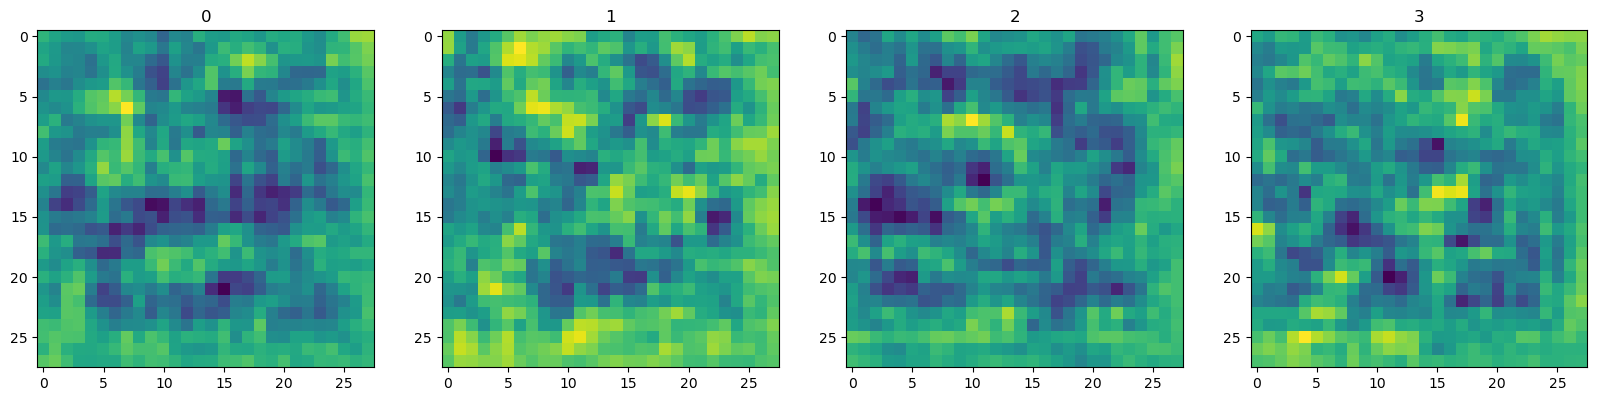

In [16]:
fig, ax = plt.subplots(ncols= 4, figsize=(20, 20))

for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

## discriminator

In [17]:
def build_discriminator():

    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation= 'sigmoid'))
    
    return model

In [18]:
discriminator = build_discriminator()

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
img.shape

(28, 28, 1)

In [21]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 22ms/step


In [22]:
discriminator.predict(img)

1/1 [==============================] - 0s 164ms/step


array([[0.5081588 ],
       [0.5082488 ],
       [0.50814486],
       [0.5081842 ]], dtype=float32)

## Custom Training Loop
Losses and optimizers

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [24]:
g_opt = Adam(learning_rate= 0.0001)
d_opt = Adam(learning_rate= 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

subclasses Model

In [25]:
from tensorflow.keras.models import Model
class imageGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training= False)
        
        #Training Discriminator
        with tf.GradientTape() as d_tape:
            
            yhat_real = self.discriminator(real_images, training= True)
            yhat_fake = self.discriminator(fake_images, training= True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
            d_grad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
            self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))
            
        #Training Generator
        with tf.GradientTape() as g_tape:
            
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training= True)
            
            predicted_labels = self.discriminator(gen_images, training= False)
            
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss ": total_d_loss, "g_loss ": total_g_loss}

instantiating the imageGAN subclassed model


In [26]:
imggan = imageGAN(generator, discriminator)

compiling the model


In [27]:
imggan.compile(g_opt, d_opt, g_loss, d_loss)

## Building Callback


In [28]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [29]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim= 128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs= None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(f'generated_img_{epoch}_{i}.png'))

## Training

In [30]:
%%time
hist = imggan.fit(data, epochs= 400, callbacks=[ModelMonitor()])

Epoch 1/400
469/469 [==============================] - 71s 142ms/step - d_loss : 0.5791 - g_loss : 1.0670
Epoch 2/400
469/469 [==============================] - 71s 152ms/step - d_loss : 0.3671 - g_loss : 4.3280
Epoch 3/400
469/469 [==============================] - 71s 151ms/step - d_loss : 0.2816 - g_loss : 2.7693
Epoch 4/400
469/469 [==============================] - 71s 152ms/step - d_loss : 0.3700 - g_loss : 2.2367
Epoch 5/400
469/469 [==============================] - 73s 155ms/step - d_loss : 0.6428 - g_loss : 0.5605
Epoch 6/400
469/469 [==============================] - 71s 152ms/step - d_loss : 0.6109 - g_loss : 0.4670
Epoch 7/400
469/469 [==============================] - 72s 153ms/step - d_loss : 0.7228 - g_loss : 0.5381
Epoch 8/400
469/469 [==============================] - 72s 154ms/step - d_loss : 0.6978 - g_loss : 0.6043
Epoch 9/400
469/469 [==============================] - 72s 154ms/step - d_loss : 0.6943 - g_loss : 0.6418
Epoch 10/400
469/469 [========================

## Performance Review


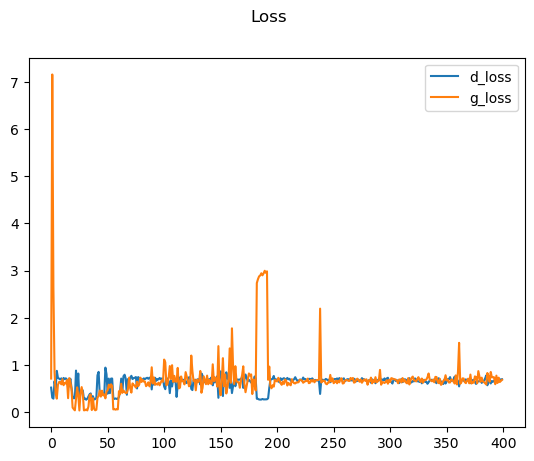

In [31]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss '], label='d_loss')
plt.plot(hist.history['g_loss '], label='g_loss')
plt.legend()
plt.show()

## Generating images using trained model


In [32]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 181ms/step


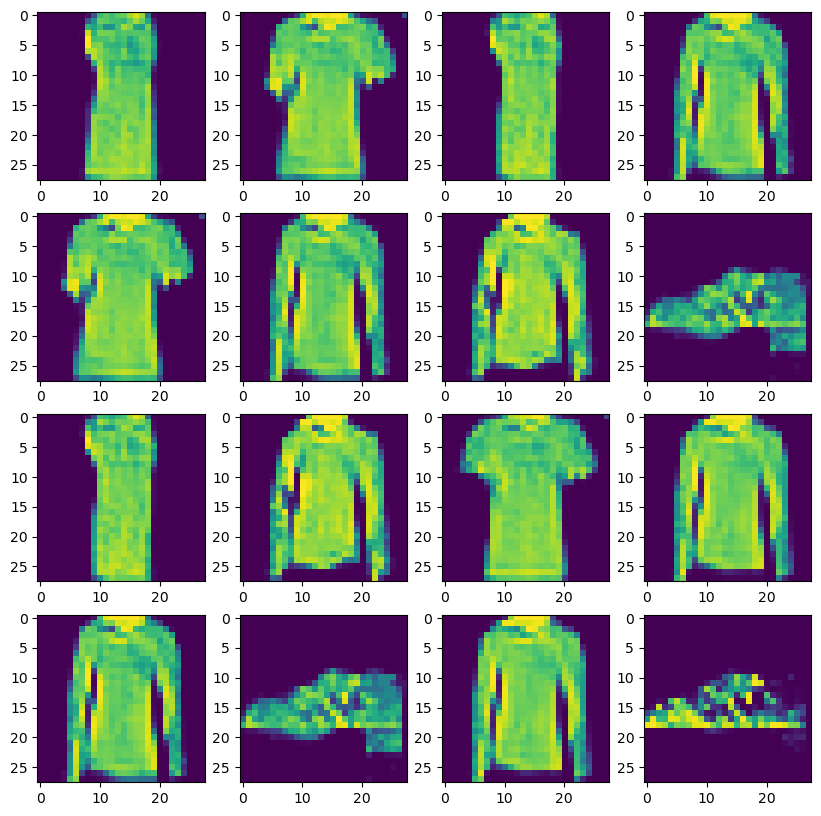

In [33]:
fig, ax = plt.subplots(ncols= 4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

## Saving the model


In [34]:
generator.save_weights('generator_weights.h5')

## Loading the saved model


In [35]:
from tensorflow.keras.models import load_model
loaded_model = build_generator()

In [36]:
loaded_model.compile()

In [37]:
loaded_model.load_weights('generator_weights.h5')

1/1 [==============================] - 0s 121ms/step


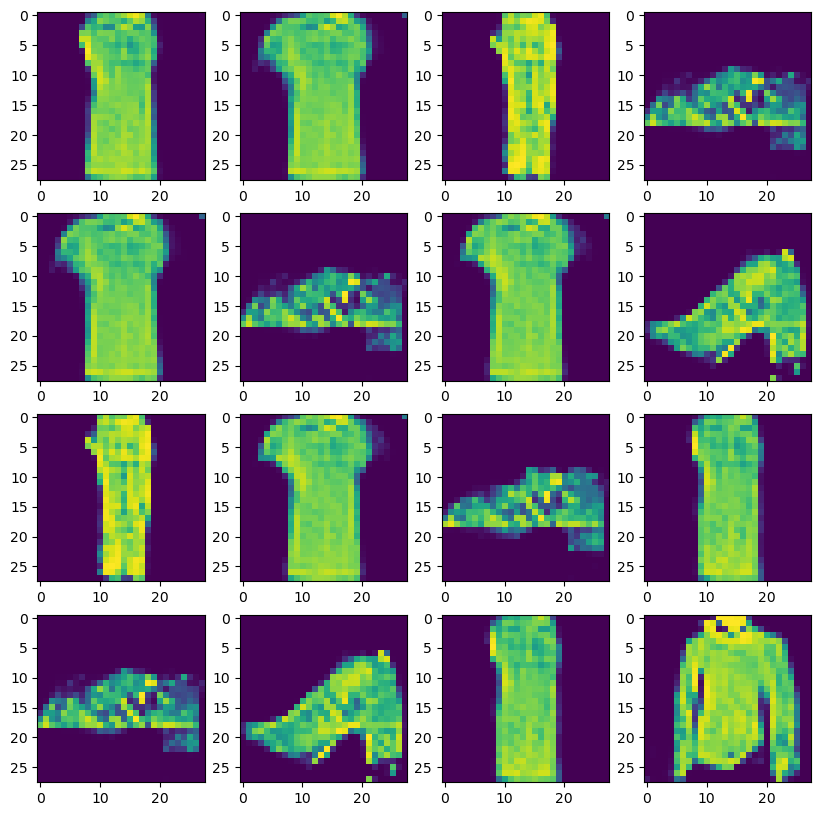

In [38]:
loaded_model_img = loaded_model.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols= 4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(loaded_model_img[(r+1)*(c+1)-1])